# Simple Simulation Analysis

In this notebook I will analyse the output of a simple simulation. First, I load the output data of the two stations.

In [2]:
%matplotlib inline

import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from model.sim_components import Simulator

## Run simulations

Run the simulation for several settings for the batch sizes and rates

In [4]:
# Common settings of the simulation
sim_time = 20
time_delta = 0.01

# Settings dict
settings = {}
settings['demand_rate'] = 1
settings['repair_rate'] = 2
settings['Q_service'] = 2
settings['Q_repair'] = 4
settings['S_depot'] = 2
settings['S_warehouse'] = 1

demand_rates = [1]
repair_rates = [2]
s_services = [2]


# Initialise empty dataframe
sim_dfs = pd.DataFrame()

# Create and run simulator for all settings
for demand_rate in demand_rates:
    for repair_rate in repair_rates:
        for s_service in s_services:
            # Set parameters
            settings['demand_rate'] = demand_rate
            settings['repair_rate'] = repair_rate
            settings['S_depot'] = s_service
            
            # Run simulation
            simulator = Simulator(time_delta, sim_time, settings)
            simulator.run()
            
            # Save output to master data frame
            sim_data = simulator.create_output_df()
            for setting, value in settings.items():
                sim_data[setting] = value
                
            sim_dfs = sim_dfs.append(sim_data)
            
# Change time column
sim_dfs.time = sim_dfs.time * time_delta

100%|██████████| 2000/2000 [00:04<00:00, 485.30it/s]


## Visualisation of stock over time

The stock levels of the repairable and servicable units are recorded over time. Let's check these.

In [5]:
# Get a feeling for the data
sim_dfs.head()

,service_stock_depot,service_stock_position,repair_stock_depot,time,service_stock_warehouse,repair_stock_warehouse,repair_shipment,service_order,order_cost_service,order_cost_repair,hold_cost_serviceables,back_cost_serviceables,hold_cost_repairables,costs,demand_rate,repair_rate,Q_service,Q_repair,S_depot,S_warehouse
0,3.99,3.99,0.01,0.00,-1,0,0,1,1,0,0.0798,-0.0,0.0299,1.1097,1,2,2,4,2,1
1,3.98,3.98,0.02,0.01,-1,0,0,0,0,0,0.0796,-0.0,0.0298,0.1094,1,2,2,4,2,1
2,3.97,3.97,0.03,0.02,-1,0,0,0,0,0,0.0794,-0.0,0.0297,0.1091,1,2,2,4,2,1
3,3.96,3.96,0.04,0.03,-1,0,0,0,0,0,0.0792,-0.0,0.0296,0.1088,1,2,2,4,2,1
4,3.95,3.95,0.05,0.04,-1,0,0,0,0,0,0.079,-0.0,0.0295,0.1085,1,2,2,4,2,1


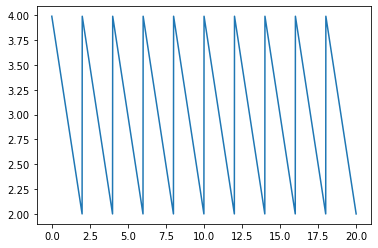

In [6]:
plt.plot(sim_dfs['time'], sim_dfs['service_stock_depot'])

In [7]:
# Get all relevant inventory level variables
# Create long format
inventory_data = sim_dfs.melt(value_vars=['service_stock_depot', 'service_stock_position', 'repair_stock_depot',
                                          'service_stock_warehouse', 'repair_stock_warehouse'], 
                              id_vars=['time'] + list(settings.keys()),
                              value_name='inventory_level', var_name='inventory_type'
                              )

# Plot lines over time 
g = sns.FacetGrid(inventory_data[inventory_data.time >= 0], col='Q_repair', col_wrap=1, hue='inventory_type', aspect=3, sharey=False)

# Plot lines
g.map(plt.plot, 'time', 'inventory_level').add_legend().set_axis_labels('Time', 'Inventory level')

NameError: name 'sim_dfs_long' is not defined

## Compute the average cycle cost

In this simple model, we assume that sending a batch from the warehouse to the depot has a cost `c_d` and sending a batch of repairable units from the depot to the warehouse costs `c_r`. In general we have that `c_r` > `c_d`, since the reverse flow is typically less efficient. Besides, set-up costs for orders, a holding costs of `h_d` per unit per unit of time for stock of servicable units at the depot has to be paid. In case of a shortage, a backlogging cost of `b_d` per unit per unit of time is incurred. For now, I do not assume any holding cost for the repairable units.

In [36]:
# Take data for one cycle
cycle_data = all_data.query('5 <= time <= 10')

# Get all order events
depot_events = pd.read_csv('../outputdepot_events.csv', index_col=0).query('5 <= time <= 10')
warehouse_events = pd.read_csv('../output/warehouse_events.csv', index_col=0).query('5 <= time <= 10')

# Count orders
n_order_depot = depot_events.shape[0]
n_order_warehouse = warehouse_events.shape[0]

# Inventory in numpy
depot_stock = cycle_data.depot_service_stock.to_numpy()

# Compute costs
total_order_costs = n_order_depot * c_r + n_order_warehouse * c_d
total_var_costs = depot_stock.clip(min=0).sum() * h_d + np.sum(-depot_stock.clip(max=0)) * b_d

print(total_order_costs + total_var_costs)

19.950000000001072


### Average inventory levels per cycle

In [ ]:
cycle_data.